# Credit Risk Prediction: "Give Me Some Credit"

## Project Overview
Predicting the probability that borrowers will experience financial distress in the next two years using machine learning. This tackles a core challenge in banking - accurately assessing credit risk to make better lending decisions.

## Dataset
- **250,000 borrower records** from Kaggle's "Give Me Some Credit" competition
- **Target**: Binary classification (serious delinquency 90+ days past due)
- **Features**: 10 financial variables (credit utilization, income, age, debt ratios, payment history)

## Goals
1. Build ML models to predict financial distress (target AUC > 0.85)
2. Identify key risk factors through EDA and feature importance
3. Compare model performance (Logistic Regression, Random Forest, XGBoost)
4. Develop actionable insights for credit decision-making

---
*Improving credit scoring through data science to help banks make better lending decisions and borrowers access appropriate credit.*

In [1274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [1277]:
# load training data
training = pd.read_csv('cs-training.csv')
training.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [1279]:
# load testing data
testing = pd.read_csv('cs-test.csv')
testing.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


## Data Preprocessing

The dataset required moderate cleaning to handle data quality issues:

**Missing Values:**
- `MonthlyIncome`: Filled NAs with median (preserves distribution)
- `NumberOfDependents`: Filled NAs with median

**Data Quality Issues:**
- Removed 1 row with invalid age (age = 0)
- Capped extreme outliers at 99th percentile to remove obvious data entry errors:
  - `DebtRatio`: Capped at 4979.08 (was 329,664%)
  - `RevolvingUtilizationOfUnsecuredLines`: Capped at 1.09 (was 50,708%)
  - `NumberOfTime30-59DaysPastDueNotWorse`: Capped at 4 instances
  - `NumberOfTime60-89DaysPastDueNotWorse` : Capped at 2 instances

**Data Structure:**
- Moved target variable `SeriousDlqin2yrs` to final column for clarity
- Remove `Unnamed: 0` column

**Result:** Clean dataset ready for EDA and modeling with 149,999 complete records.

---

In [1282]:
# move dependent variable (SeriousDlqin2yrs) to the end
training['SeriousDlqin2yrs'] = training.pop('SeriousDlqin2yrs')
training.head()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


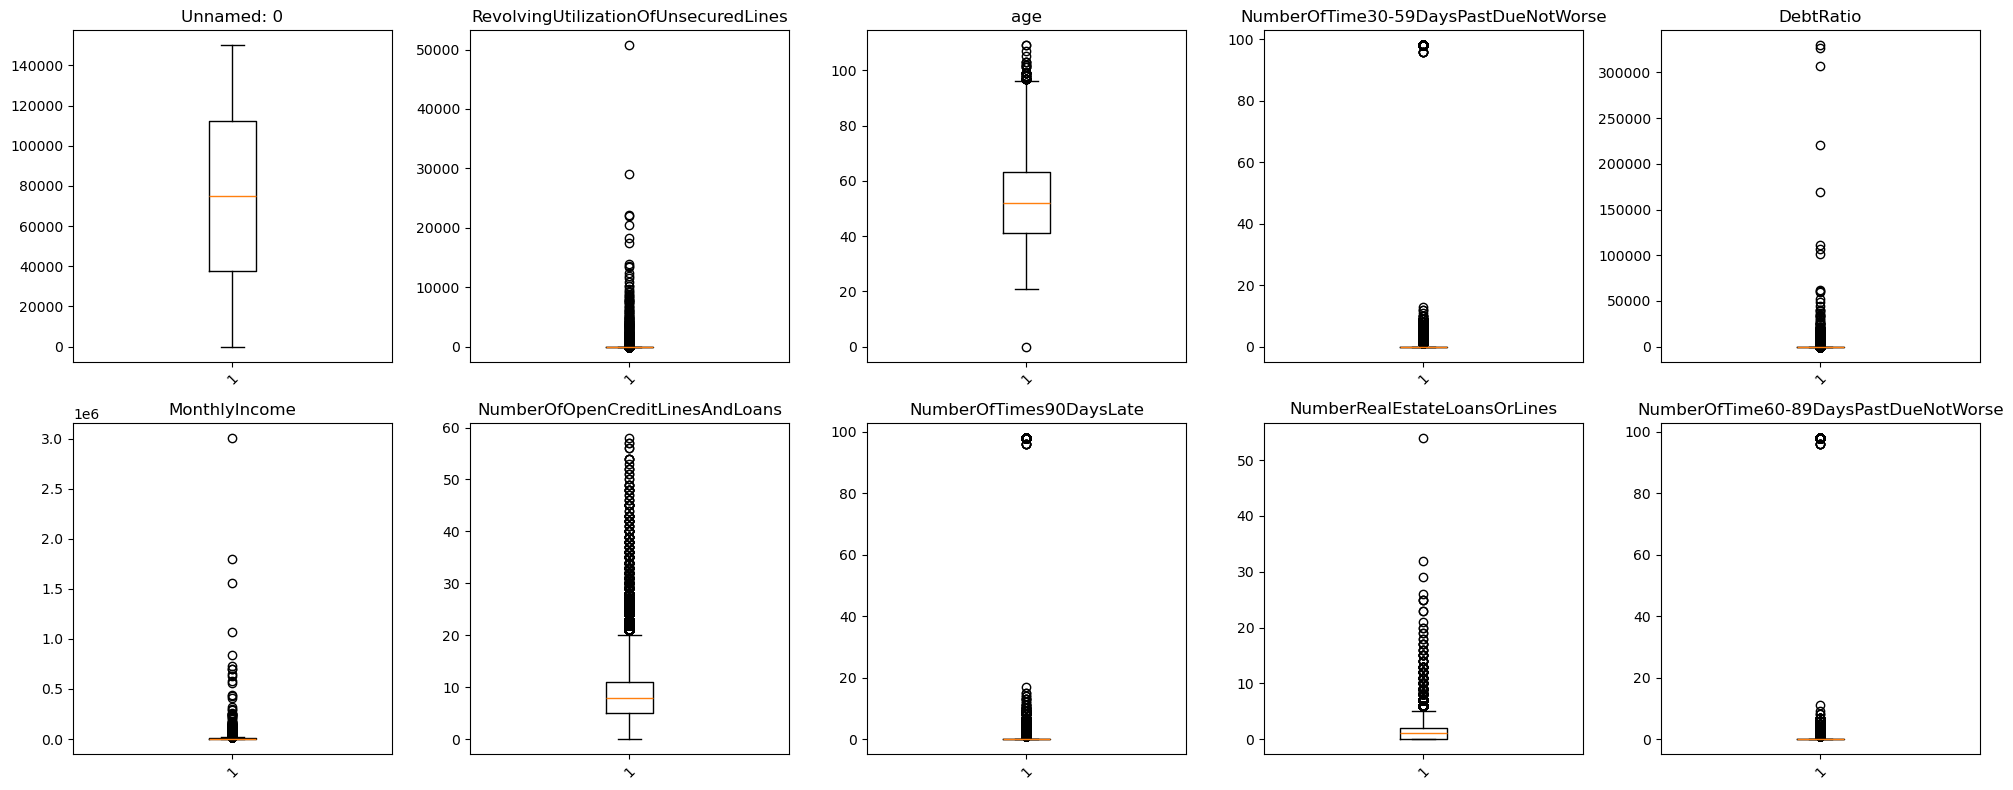

In [1284]:
# check for outliers in training data (common in financial data and important for storytelling)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

numeric_cols = training.select_dtypes(include=['float64', 'int64']).columns

for i, col in enumerate(numeric_cols):
    if i < 10:  
        axes[i].boxplot(training[col].dropna())
        axes[i].set_title(f'{col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [1285]:
# check basic stats
print(training.describe())

          Unnamed: 0  RevolvingUtilizationOfUnsecuredLines            age  \
count  150000.000000                         150000.000000  150000.000000   
mean    75000.500000                              6.048438      52.295207   
std     43301.414527                            249.755371      14.771866   
min         1.000000                              0.000000       0.000000   
25%     37500.750000                              0.029867      41.000000   
50%     75000.500000                              0.154181      52.000000   
75%    112500.250000                              0.559046      63.000000   
max    150000.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033     353.005076   6.670221e+03   
std                                4.192781    2037.818523   1.438467e+04  

#### Initial Data Analysis

The dataset reveals several key characteristics that will impact our modeling approach. Most notably, we're dealing with a **highly imbalanced dataset** with only 6.7% of borrowers experiencing serious delinquency, requiring careful handling during model training. The data contains some clear outliers and potential data quality issues - credit utilization rates exceeding 50,000%, ages of 0, excessive amounts of time past due in the past 2 years, and debt ratios over 300,000% suggest either data entry errors or extreme edge cases that need investigation. Missing data is primarily concentrated in `MonthlyIncome` (20% missing) and `NumberOfDependents` (3% missing), which may itself be informative since borrowers might intentionally omit income information. The distribution patterns show that most borrowers have relatively normal financial profiles (median credit utilization of 15%, median age of 52), but the extreme values in the tail could be the most predictive of default risk, making outlier treatment a critical decision for model performance.

In [1289]:
# check how many of age 0 there are
print("Age = 0:", (training['age'] == 0).sum())

# remove row with age 0
training = training[training['age'] > 0]
print(f"Removed 1 row. New dataset size: {len(training)}")

Age = 0: 1
Removed 1 row. New dataset size: 149999


In [1291]:
# debt ratio of 300,000% seems quite unreasonable, so i will cap at the 99th percentile
print("DebtRatio 99th percentile:", training['DebtRatio'].quantile(0.99))

# replace out of range values with 99th percentile
debt_cap = training['DebtRatio'].quantile(0.99)
training['DebtRatio'] = training['DebtRatio'].clip(upper=debt_cap)

print(f"Capped DebtRatio at {debt_cap:.2f}")

DebtRatio 99th percentile: 4979.079999999958
Capped DebtRatio at 4979.08


In [1293]:
# RevolvingUtilizationOfUnsecuredLines of max 50,000 seems quite unreasonable, so i will again cap at 99th percentile
print("RevolvingUtilizationOfUnsecuredLines 99th percentile:", training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99))

# replace out of range values with 99th percentile
unsecured_lines_cap = training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)
training['RevolvingUtilizationOfUnsecuredLines'] = training['RevolvingUtilizationOfUnsecuredLines'].clip(upper=unsecured_lines_cap)

print(f"Capped RevolvingUtilizationOfUnsecuredLines at {unsecured_lines_cap: .2f}")

RevolvingUtilizationOfUnsecuredLines 99th percentile: 1.0929580132799976
Capped RevolvingUtilizationOfUnsecuredLines at  1.09


In [1295]:
# the max of 98 for NumberOfTime30-59DaysPastDueNotWorse seems a bit odd, as there are only 24 months in two years. 
# Not sure if its possible to miss so many times in that short period.
print('NumberOfTime30-59DaysPastDueNotWorse:' , training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.99))

# replace out of range values with 99th percentile
num_times_30 = training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.99)
training['NumberOfTime30-59DaysPastDueNotWorse'] = training['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=num_times_30)

print(f"Capped NumberOfTime30-59DaysPastDueNotWorse at {num_times_30: .2f}")

NumberOfTime30-59DaysPastDueNotWorse: 4.0
Capped NumberOfTime30-59DaysPastDueNotWorse at  4.00


In [1297]:
# the max of 98 for NumberOfTime60-89DaysPastDueNotWorse seems a bit odd, as there are only 24 months in two years. 
# Not sure if its possible to miss so many times in that short period.
print('NumberOfTime60-89DaysPastDueNotWorse:' , training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.99))

# replace out of range values with 99th percentile
num_times_60 = training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.99)
training['NumberOfTime60-89DaysPastDueNotWorse'] = training['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=num_times_30)

print(f"Capped NumberOfTime60-89DaysPastDueNotWorse at {num_times_60: .2f}")

NumberOfTime60-89DaysPastDueNotWorse: 2.0
Capped NumberOfTime60-89DaysPastDueNotWorse at  2.00


In [1299]:
# check basic stats again
training.describe()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000,1.202680e+05,149999.000000,149999.000000,149999.000000,149999.000000,146075.000000,149999.000000
mean,75000.562030,0.320491,52.295555,0.245855,316.551377,6.670227e+03,8.452776,0.265975,1.018233,0.071127,0.757214,0.066840
std,43301.552202,0.352149,14.771298,0.666815,906.966934,1.438473e+04,5.145964,4.169318,1.129772,0.358687,1.115085,0.249746
min,1.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.500000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75001.000000,0.154176,52.000000,0.000000,0.366503,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,112500.500000,0.559044,63.000000,0.000000,0.868257,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,150000.000000,1.092958,109.000000,4.000000,4979.080000,3.008750e+06,58.000000,98.000000,54.000000,4.000000,20.000000,1.000000


#### Null Removal

In [1302]:
# check for null values in training data
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149999 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            149999 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149999 non-null  float64
 2   age                                   149999 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149999 non-null  int64  
 4   DebtRatio                             149999 non-null  float64
 5   MonthlyIncome                         120268 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149999 non-null  int64  
 7   NumberOfTimes90DaysLate               149999 non-null  int64  
 8   NumberRealEstateLoansOrLines          149999 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149999 non-null  int64  
 10  NumberOfDependents                    146075 non-null  float64
 11  Serio

In [1304]:
# drop Unnamed: 0 col
training = training.drop(['Unnamed: 0'] , axis = 1)

# remove nulls from MonthlyIncome
training['MonthlyIncome'] = training['MonthlyIncome'].fillna(training['MonthlyIncome'].median())

# remove nulls from NumberOfDependents
training['NumberOfDependents'] = training['NumberOfDependents'].fillna(training['NumberOfDependents'].median())

training.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


In [1306]:
# verify no null values remain
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149999 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  149999 non-null  float64
 1   age                                   149999 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  149999 non-null  int64  
 3   DebtRatio                             149999 non-null  float64
 4   MonthlyIncome                         149999 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       149999 non-null  int64  
 6   NumberOfTimes90DaysLate               149999 non-null  int64  
 7   NumberRealEstateLoansOrLines          149999 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149999 non-null  int64  
 9   NumberOfDependents                    149999 non-null  float64
 10  SeriousDlqin2yrs                      149999 non-null  int64  
dtypes: fl

In [1308]:
# check for null values in training data
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [1310]:
# drop dependent variable (SeriousDlqin2yrs) and Unnamed: 0 from testing 
testing = testing.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis = 1)
testing.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [1312]:
# remove nulls from MonthlyIncome
testing['MonthlyIncome'] = testing['MonthlyIncome'].fillna(testing['MonthlyIncome'].median())
# remove nulls from NumberOfDependents
testing['NumberOfDependents'] = testing['NumberOfDependents'].fillna(testing['NumberOfDependents'].median())

testing.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [1314]:
# verify no null values remain
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 1   age                                   101503 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 3   DebtRatio                             101503 non-null  float64
 4   MonthlyIncome                         101503 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 6   NumberOfTimes90DaysLate               101503 non-null  int64  
 7   NumberRealEstateLoansOrLines          101503 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 9   NumberOfDependents                    101503 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 7.7 MB


## Create Classifier Function
I will create a reusable function to streamline the model training and evaluation process:

**Function Purpose:**
- Train any classifier on the training data
- Perform 5-fold cross-validation to assess model performance
- Calculate AUC-ROC scores (appropriate for imbalanced binary classification)
- Return mean AUC scores to compare model ranking ability

**Why AUC-ROC:**
- More meaningful than accuracy for imbalanced datasets
- Measures how well the model distinguishes between defaulters and non-defaulters
- Standard metric used in credit risk modeling
- Not influenced by class distribution imbalance
---

In [1317]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# set matricies X_train and X_test to store all predictor variablesand
X_train = training.iloc[:, :-1]
X_test = testing

# set y_train to store all response variables
y_train = training.iloc[:,-1]

In [1319]:
# features are on many different scales, thus i will scale them to theyre on similar numerical ranges
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit on training data
X_test = scaler.transform(X_test) # transform test data with same scaler

In [1321]:
def clf_model(model):
    clf = model
    scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)
    print('AUC Scores:', scores)
    print('Mean AUC:', scores.mean())
    return clf

## Create Confusion Matrix Function
I will create a function to generate detailed performance analysis for each model:

**Function Purpose:**
- Split training data into train/validation sets (80/20)
- Train the model on the training portion
- Evaluate on the validation portion to generate confusion matrix
- Provide classification report with precision, recall, and F1-scores
- Return the trained model for further use

This function will provide comprehensive insights into how well each model distinguishes between defaulters and non-defaulters.

---

In [1324]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# since we aren't provided SeriousDlqin2yrs for test data, we will split the training data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# create function generating confusion matrix for the model
def confusion(model):
    clf = model
    clf.fit(X_train_split, y_train_split)
    y_pred = clf.predict(X_val)
    print('Confusion Matrix:' , confusion_matrix(y_val, y_pred))
    print('Classification Report:', classification_report(y_val, y_pred))
    return clf

## Model Selection
I will test multiple classification algorithms to find the best performer for credit risk prediction:

**Algorithms to Test:**
* Logistic Regression (baseline linear model)
* Logistic Regression with balanced class weights
* Random Forest (ensemble method) 
* Random Forest with balanced class weights
* Decision Tree (single tree approach)
* Decision Tree with balanced class weights
* Gaussian Naive Bayes (probabilistic approach)
* K-Nearest Neighbors (distance-based)
* AdaBoost (boosting ensemble)

**Evaluation Method:** Each model will be evaluated using 5-fold cross-validation with AUC-ROC as the primary metric (appropriate for imbalanced binary classification). Selected models will also be analyzed using confusion matrices to assess precision, recall, and business impact for both default and non-default classes.

---

#### Logistic Regression

In [1336]:
from sklearn.linear_model import LogisticRegression
lr_model = clf_model(LogisticRegression(max_iter = 5000, random_state=42))
print(lr_model)

AUC Scores: [0.83553206 0.83059881 0.83575572 0.83811129 0.84277342]
Mean AUC: 0.8365542586394902
LogisticRegression(max_iter=5000, random_state=42)


In [1338]:
# genarate confusion matrix
confusion(LogisticRegression(max_iter=5000, random_state=42))  

Confusion Matrix: [[27826   215]
 [ 1706   253]]
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.99      0.97     28041
           1       0.54      0.13      0.21      1959

    accuracy                           0.94     30000
   macro avg       0.74      0.56      0.59     30000
weighted avg       0.92      0.94      0.92     30000



LogisticRegression(max_iter=5000, random_state=42)

In [1340]:
# also try with balanced class_weight
lr_model_balance = clf_model(LogisticRegression(class_weight='balanced', max_iter = 5000, random_state=42))
print(lr_model_balance)

AUC Scores: [0.84341598 0.83816265 0.84354384 0.84412372 0.85040088]
Mean AUC: 0.8439294138855955
LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)


In [1342]:
confusion(LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42))  

Confusion Matrix: [[21917  6124]
 [  500  1459]]
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.78      0.87     28041
           1       0.19      0.74      0.31      1959

    accuracy                           0.78     30000
   macro avg       0.59      0.76      0.59     30000
weighted avg       0.93      0.78      0.83     30000



LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

#### Random Forest

In [1345]:
from sklearn.ensemble import RandomForestClassifier
rf_model = clf_model(RandomForestClassifier(random_state = 42))
print(rf_model)

AUC Scores: [0.83441834 0.83803559 0.83961421 0.84364708 0.84581358]
Mean AUC: 0.8403057569795894
RandomForestClassifier(random_state=42)


In [1346]:
# genarate confusion matrix
confusion(RandomForestClassifier(random_state = 42))

Confusion Matrix: [[27704   337]
 [ 1593   366]]
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28041
           1       0.52      0.19      0.27      1959

    accuracy                           0.94     30000
   macro avg       0.73      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000



RandomForestClassifier(random_state=42)

In [1347]:
rf_model_balance = clf_model(RandomForestClassifier(class_weight='balanced', random_state = 42))

AUC Scores: [0.83198387 0.8315902  0.83491376 0.83808832 0.84165764]
Mean AUC: 0.8356467559263226


In [1348]:
# genarate confusion matrix
confusion(RandomForestClassifier(class_weight='balanced', random_state = 42))

Confusion Matrix: [[27758   283]
 [ 1658   301]]
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.99      0.97     28041
           1       0.52      0.15      0.24      1959

    accuracy                           0.94     30000
   macro avg       0.73      0.57      0.60     30000
weighted avg       0.92      0.94      0.92     30000



RandomForestClassifier(class_weight='balanced', random_state=42)

#### Decision Tree

In [1353]:
from sklearn.tree import DecisionTreeClassifier
dt_model = clf_model(DecisionTreeClassifier(random_state = 42))

AUC Scores: [0.61410123 0.61387129 0.62109577 0.61078663 0.61270383]
Mean AUC: 0.6145117491833397


In [1354]:
# genarate confusion matrix
confusion(DecisionTreeClassifier(random_state = 42))

Confusion Matrix: [[26396  1645]
 [ 1429   530]]
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.94      0.94     28041
           1       0.24      0.27      0.26      1959

    accuracy                           0.90     30000
   macro avg       0.60      0.61      0.60     30000
weighted avg       0.90      0.90      0.90     30000



DecisionTreeClassifier(random_state=42)

In [1355]:
# also try with balanced class_weight
dt_model_balance = clf_model(DecisionTreeClassifier(class_weight='balanced', random_state = 42))

AUC Scores: [0.60298194 0.60009963 0.59902045 0.60460728 0.61026782]
Mean AUC: 0.6033954253120463


In [1356]:
# genarate confusion matrix
confusion(DecisionTreeClassifier(class_weight='balanced', random_state = 42))

Confusion Matrix: [[26568  1473]
 [ 1479   480]]
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.95      0.95     28041
           1       0.25      0.25      0.25      1959

    accuracy                           0.90     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.90      0.90      0.90     30000



DecisionTreeClassifier(class_weight='balanced', random_state=42)

#### GaussianNB

In [1366]:
from sklearn.naive_bayes import GaussianNB
gnb_model = clf_model(GaussianNB())
print(gnb_model)

AUC Scores: [0.83498541 0.8283114  0.83208873 0.83434518 0.84045543]
Mean AUC: 0.834037227621671
GaussianNB()


In [1368]:
# genarate confusion matrix
confusion(GaussianNB())

Confusion Matrix: [[26787  1254]
 [ 1229   730]]
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.96      0.96     28041
           1       0.37      0.37      0.37      1959

    accuracy                           0.92     30000
   macro avg       0.66      0.66      0.66     30000
weighted avg       0.92      0.92      0.92     30000



GaussianNB()

#### KNeighborsClassifier

In [1371]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = clf_model(KNeighborsClassifier())
print(kn_model)

AUC Scores: [0.727935   0.72230612 0.72924979 0.72655643 0.72997498]
Mean AUC: 0.7272044653403079
KNeighborsClassifier()


In [1375]:
confusion(KNeighborsClassifier())

Confusion Matrix: [[27611   430]
 [ 1627   332]]
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.98      0.96     28041
           1       0.44      0.17      0.24      1959

    accuracy                           0.93     30000
   macro avg       0.69      0.58      0.60     30000
weighted avg       0.91      0.93      0.92     30000



KNeighborsClassifier()

#### AdaBoost

In [1377]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = clf_model(AdaBoostClassifier(algorithm='SAMME', random_state=42))
print(ada_model)

AUC Scores: [0.85247012 0.8517973  0.85608853 0.85302398 0.86064901]
Mean AUC: 0.8548057887261228
AdaBoostClassifier(algorithm='SAMME', random_state=42)


In [1378]:
confusion(AdaBoostClassifier(algorithm='SAMME', random_state=42))

Confusion Matrix: [[27735   306]
 [ 1613   346]]
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28041
           1       0.53      0.18      0.27      1959

    accuracy                           0.94     30000
   macro avg       0.74      0.58      0.62     30000
weighted avg       0.92      0.94      0.92     30000



AdaBoostClassifier(algorithm='SAMME', random_state=42)

### Summary Table

In [1382]:
# create table that concatenates all results in easily readable format

model_results = {
    'Logistic Regression' : 0.8366,
    'Logistic Regression (Balanced)' : 0.8439,
    'Random Forest' : 0.8403,  
    'Random Forest (Balanced)' : 0.8356,
    'Decision Tree' : 0.6145,
    'Decision Tree (Balanced)' : 0.6034,
    'GaussianNB' : 0.8340,
    'KNeighbors' : 0.7272,
    'AdaBoost' : 0.8548
}

# convert to sorted data frame
summary_df = pd.DataFrame(list(model_results.items()), columns = ['Model' , 'AUC Score']).sort_values('AUC Score' , ascending = False)
summary_df

,Model,AUC Score
8,AdaBoost,0.8548
1,Logistic Regression (Balanced),0.8439
2,Random Forest,0.8403
0,Logistic Regression,0.8366
3,Random Forest (Balanced),0.8356
6,GaussianNB,0.8340
7,KNeighbors,0.7272
4,Decision Tree,0.6145
5,Decision Tree (Balanced),0.6034


## Model Selection Conclusion

**Winner: AdaBoost Classifier**
- **AUC Score:** 0.855 (excellent performance)
- **Best overall ranking ability** among all tested algorithms

### Performance Analysis

**Strengths:**
- **Excellent AUC score (0.855):** Demonstrates superior ability to rank borrowers by default risk
- **High precision for safe borrowers (95%):** Minimizes unnecessary loan rejections
- **Low false positive rate (1.1%):** Only 306 good borrowers incorrectly flagged as risky
- **Robust ensemble approach:** AdaBoost's sequential learning reduces overfitting risk

**Key Challenge:**
- **Low recall for defaults (18%):** Only detects 346 out of 1,959 actual defaulters
- **Misses 82% of risky borrowers:** 1,613 defaults would slip through undetected

### Business Impact

**Conservative Risk Approach:**
The model prioritizes avoiding false alarms over catching every default. This translates to:
- **Risk exposure:** The model would approve 1,613 loans that will default, representing substantial financial risk (actual loss depends on loan sizes and recovery rates)
- **Competitive advantage:** Low rejection rate for good customers (99% approval for safe borrowers)

**Final Verdict:** AdaBoost is recommended as the primary credit scoring model due to its superior AUC performance and robust ensemble methodology.

---

### Submission

In [1393]:
# sets the final submission model to AdaBoost
final_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
final_model.fit(X_train, y_train)

# make probability predictions on test data
test_probabilities = final_model.predict_proba(X_test)[:, 1] 

# create submission dataframe
submission = pd.DataFrame({
    'Id': range(1, len(test_probabilities) + 1),  
    'Probability': test_probabilities
})

# save to CSV
submission.to_csv('give_me_some_credit_submission.csv', index=False)

# check the first few rows
print(submission.head())

   Id  Probability
0   1     0.357151
1   2     0.319279
2   3     0.280969
3   4     0.378397
4   5     0.370032


In [1395]:
len(submission)

101503

## Conclusion

**Final Results**
- **Kaggle Scores:** Public: 0.84895, Private: 0.85711
- **Cross-Validation AUC:** 0.855

This credit risk prediction project achieved excellent performance through systematic model evaluation and proper handling of imbalanced data.

**Key Findings**
* **AdaBoost Classifier** outperformed all other algorithms with AUC of 0.857
* Feature scaling and outlier capping (99th percentile) were crucial for model stability
* AUC-ROC proved essential over accuracy for evaluating imbalanced datasets (6.7% default rate)
* Ensemble methods like AdaBoost provided superior ranking ability compared to simple linear models

**Methodology Success**
The systematic approach of testing 9 different algorithms (including class-balanced variants), using 5-fold cross-validation, and thorough evaluation with both AUC scores and confusion matrices led to optimal model selection and reliable results.

**What I Learned**
The biggest lesson was realizing that accuracy is basically useless for imbalanced data - I was so confused why my 94% accuracy model seemed worse until I switched to AUC-ROC. Also learned that feature scaling matters way more than expected (LogisticRegression threw convergence warnings until I scaled) and that financial outliers require careful consideration - some extreme values are data errors while others are legitimate risk indicators.

**Result: AUC 0.857** - Strong performance demonstrating effective credit risk modeling for financial decision-making!